# 01 Setup

In [1]:
!pip install medvqa -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Install required libraries
!pip install --upgrade pip
!pip install "wandb>=0.15"
!pip install transformers==4.51.3
!pip install datasets evaluate rouge_score einops timm peft
!pip install "accelerate>=0.26.0"
!pip install python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 54.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.7 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [wandb]m10/11 [wandb]ic]k]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 46.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.3 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [transformers] [transformers]
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.1 MB/s eta

In [ ]:
!pip install "typing_extensions>=4.6.0" --upgrade --force-reinstall
!pip install --upgrade Pillow
import os
os.kill(os.getpid(), 9)  # This restarts the runtime

  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 35.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0


# 02 Load Dataset, Model

In [1]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HF_TOKEN")

login(token=hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [21]:
# Import necessary modules
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoProcessor, Trainer, TrainingArguments
import torch
from peft import get_peft_model, LoraConfig, TaskType

MODEL_NAME = "microsoft/Florence-2-base-ft"

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Florence-2 model
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, trust_remote_code=True)

# # <-- Apply LoRA adaptation on top of base model
# lora_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "lm_head", "fc2"],
#     task_type=TaskType.CAUSAL_LM,
#     lora_dropout=0.05478,
#     bias="none",
#     inference_mode=False,
# )

# model = get_peft_model(model, lora_config)
model = model.to(device)

# Load processor
processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)

total_params = sum(p.numel() for p in model.parameters())
print(f'total parameters: {total_params}')

# Freeze vision tower
for param in model.vision_tower.parameters():
    param.requires_grad = False
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'trainable parameters: {trainable_params} {trainable_params/total_params:.2f}')

total parameters: 270803968
trainable parameters: 180435968 0.67


In [22]:
# Load dataset
DATASET_COVERAGE = 1
SEED = 7
TEST_SIZE = 0.1

ds = load_dataset("SimulaMet-HOST/Kvasir-VQA")['raw']

if DATASET_COVERAGE < 1:
    dataset = ds.train_test_split(test_size=DATASET_COVERAGE, seed=SEED, shuffle=True)
    dataset = dataset['test'].train_test_split(test_size=TEST_SIZE, seed=SEED)
    train_dataset, val_dataset = dataset['train'], dataset['test']
else:
    dataset = ds.train_test_split(test_size=TEST_SIZE, seed=SEED)
    train_dataset, val_dataset = dataset['train'], dataset['test']

train_dataset.shape, val_dataset.shape, train_dataset.shape[0] + val_dataset.shape[0], ds.shape

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

((52964, 5), (5885, 5), 58849, (58849, 5))

In [23]:
def collate_fn(batch):
    questions = [f"{x['question']}" for x in batch]
    images = [x["image"].convert("RGB") if x["image"].mode != "RGB" else x["image"] for x in batch]
    answers = [x["answer"] for x in batch]

    inputs = processor(text=questions, images=images, return_tensors="pt", padding=True)
    labels = processor.tokenizer(answers, return_tensors="pt", padding=True).input_ids
    labels[labels == processor.tokenizer.pad_token_id] = -100
    inputs["labels"] = labels
    return inputs

# 03 Error Metrics

In [24]:
# (optional) if you want to evaluate with NLP or other metrics
import evaluate
import numpy as np

bleu, meteor, rouge = map(evaluate.load, ["bleu", "meteor", "rouge"])

# def compute_metrics(eval_pred):
#     preds, labels = eval_pred
#     preds = processor.tokenizer.batch_decode(np.argmax(preds[0], axis=-1), skip_special_tokens=True)
#     labels = processor.tokenizer.batch_decode(np.where(labels != -100, labels, processor.tokenizer.pad_token_id), skip_special_tokens=True)
#     preds, labels = [p.strip() for p in preds], [l.strip() for l in labels]

#     return {
#         # "bleu": bleu.compute(predictions=preds, references=[[l] for l in labels])["bleu"],
#         # "meteor": meteor.compute(predictions=preds, references=labels)["meteor"],
#         "rougeL": rouge.compute(predictions=preds, references=labels)["rougeL"],
#     }

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: parajuligaurav007 (MedPixel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [30]:
import math

# ==== Hyperparameters ====
MODEL_NAME = 'florence2'
TRAIN_DATASET_SIZE = len(train_dataset)

PER_DEVICE_TRAIN_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 16
PER_DEVICE_EVAL_BATCH_SIZE = 4
EVAL_ACCUMULATION_STEPS = 1
BASE_LEARNING_RATE = 9.6e-5
WEIGHT_DECAY = 0.07

NUM_EPOCHS = 3
LOGGING_STEPS = 10

# ==== Derived Values ====
effective_batch_size = PER_DEVICE_TRAIN_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS
scaled_learning_rate = BASE_LEARNING_RATE * math.sqrt((effective_batch_size / PER_DEVICE_TRAIN_BATCH_SIZE))
steps_per_epoch = math.ceil(TRAIN_DATASET_SIZE / effective_batch_size)
max_steps = steps_per_epoch * NUM_EPOCHS

run_name = f"{MODEL_NAME}_{effective_batch_size}_FT"

# ==== Training Arguments ====
training_args = TrainingArguments(
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=f"gauravparajuli/{run_name}",
    # output_dir="./Florence-2-vqa",
    output_dir=run_name,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PER_DEVICE_EVAL_BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    eval_accumulation_steps=EVAL_ACCUMULATION_STEPS,
    max_steps=max_steps,
    learning_rate=BASE_LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    logging_steps=LOGGING_STEPS,
    save_strategy="steps",
    save_steps=steps_per_epoch,  # once per epoch
    eval_strategy="steps",
    eval_steps=steps_per_epoch,  # once per epoch
    report_to="wandb",
    save_total_limit=3,
    remove_unused_columns=False,
    fp16=True,
    load_best_model_at_end=True,  # <-- Save best model automatically
    # metric_for_best_model="rougeL",
    # greater_is_better=False
)

print(f'num epochs: {NUM_EPOCHS}')
print('base learning rate: ', BASE_LEARNING_RATE)
# print('scaled learning rate: ', scaled_learning_rate)
print(run_name)

num epochs: 3
base learning rate:  9.6e-05
florence2_64_FT


In [32]:
import wandb
import shutil
from transformers import EarlyStoppingCallback

wandb.init(
    project="ImageClef2025VQA",
    name=run_name,  # same run_name you're using above
    config={
        "batch_size": PER_DEVICE_TRAIN_BATCH_SIZE,
        "grad_acc_steps": GRADIENT_ACCUMULATION_STEPS,
        "effective_batch_size": effective_batch_size,
        "base_learning_rate": BASE_LEARNING_RATE,
        "num_epochs": NUM_EPOCHS,
    }
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    # compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics # if you want to evaluate with NLP or other metrics (optional)
# )

trainer.train()
wandb.finish()
shutil.rmtree(training_args.output_dir)

Step,Training Loss,Validation Loss
828,0.116300,0.105083
1656,0.076000,0.084791
2484,0.067600,0.077187


There were missing keys in the checkpoint model loaded: ['language_model.model.encoder.embed_tokens.weight', 'language_model.model.decoder.embed_tokens.weight'].


eval/loss,█▃▁
eval/runtime,▁█▆
eval/samples_per_second,█▁▃
eval/steps_per_second,█▁▃
train/epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇████
train/grad_norm,█▅▅▅▃▃▂▂▃▁▂▂▂▂▁▁▁▂▁▁▂▂▁▂▁▂▁▂▁▁▁▁▁▂▂▁▁▁▁▂
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train/loss,█▇▄▄▄▃▄▄▄▄▃▂▃▃▂▃▂▃▃▂▃▂▂▂▂▂▂▁▂▃▂▁▁▂▁▂▁▁▂▁
eval/loss,0.07719
eval/runtime,419.4204


# Inference

Q: Is there a green/black box artefact?
Model: no
GT: no


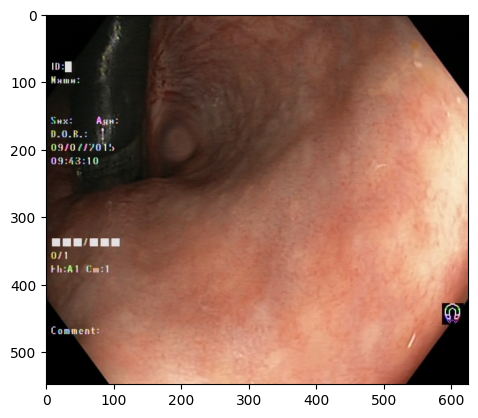

In [16]:
# ReRun this block to generate for new ramdom sample
import random
sample = [val_dataset[random.randint(0, len(val_dataset)-1)]] # rerun this block to generate new sample
import matplotlib.pyplot as plt; plt.imshow(sample[0]['image'])
inputs = collate_fn(sample)
inputs = {k: v.to(device) for k, v in inputs.items() if k not in ['labels', 'attention_mask']}

with torch.no_grad():
    output = model.generate(**inputs)

print(f"Q: {sample[0]['question']}\nModel: {processor.tokenizer.decode(output[0], skip_special_tokens=True)}\nGT: {sample[0]['answer']}")